# Deux conteneurs
## Scénario réaliste
### Caractériser le scénario
#### Description
Le but de cette expérience est d'étudier le comportement d'un conteneur exécutant `sysbench` dans un scénario bien défini.

Ce scénario peut-être découpé en 5 parties :

1. Le conteneur ne sera pas limité dans le nombre de transaction qu'il envoie à sa base de données.

2. Le conteneur n'enverra plus que 200 transactions par seconde à sa base de données.

3. Le conteneur verra son nombre de transactions envoyées illimitées.

4. Le conteneur sera limité à 200 transactions par seconde.

5. Le conteneur enverra des transactions sans limite.

Chacune ce ces parties durent 180 secondes donc le scénario se déroule en 900 secondes.

Ce scénario peut être vu comme la simulation d'un serveur web faisant face à des pics d'activité entrecoupés de période d'inactivité.

#### Modification de sysbench
Le benchmark `sysbench` a été modifié afin de changer le taux de transactions à réaliser à des moments spécifiques dans le temps.
Ainsi, le scénario présenté correspond à une exécution de `sysbench` dont le taux de transactions à réaliser change toutes les 180 secondes.

#### Environnement 
Le conteneur a été lancé dans une machine virtuelle disposant de 4 coeurs virtuels et 3GB de mémoire.

Il est lancé avec une `max` limite fixée à 1.8GB.

Les différentes exécutions n'ont pas d'impact les unes sur les autres car le cache fichier est vidé entre chaque itération.

#### Résultats attendus
Le conteneur s'exécute seul mais avec une `max` limite inférieure à la mémoire dont dipose la machine virtuelle.
Ses performances devraient donc être inférieures à celles de références car il sera freiné par sa `max` limite.

#### Conditions de l'expérience
Les expériences ont été répétées 10 fois afin de calculer une moyenne et l'écart-type associé.

Le conteneur manipule une base de données de 4GB.

Avant chaque expérience une sauvegarde de la base de données est effectuée afin de ramener celle-ci de force en mémoire et donc de gonfler la mémoire du conteneur.
Cette sauvegarde ramenera les données dans le cache fichier du noyau. Ainsi pour accèder à ces données `mysql` n'aura qu'à faire une copie de celles-ci depuis le cache fichier vers son tampon mémoire plutôt que ramener celles-ci depuis le disque.
Cette sauvegarde émule en quelque sorte le fait que `mysql` s'exécute depuis longtemps et à ramener toute la base de données dans sa mémoire.

Le script permettant de lancer le conteneur et d'obtenir des statistiques sur celui-ci est trouvable en annexe.

#### Résultats obtenus
Étudions d'abord le nombre de transactions, le nombre de requêtes et la latence de celles-ci au cours du scénario pour les deux conteneurs :

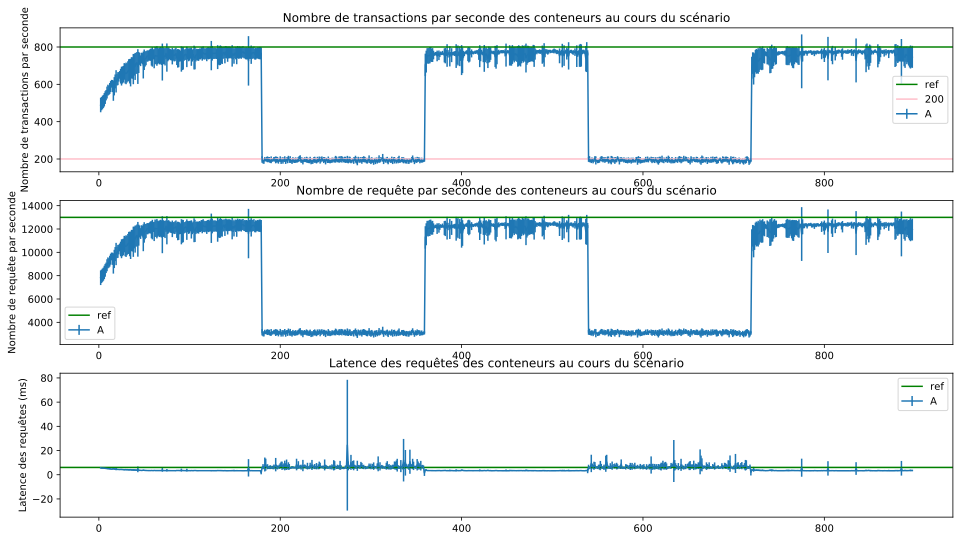

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats


TRANSACTIONS_REF_HIGH = 800
TRANSACTIONS_REF_LOW = 200
QUERIES_REF = 13000
LATENCY_REF = 6

DIR = 'alone_max_1800M'
FILES = {'A': ['container_S_silly_roentgen_1800M.out.time.csv']}
KEYS = ['transactions', 'queries', 'latencies']

DURATION = 900
NAMES = ['A']

dictionnary = {}

for key in FILES:
    dictionnary[key] = {}
    
    for k in KEYS:
        dictionnary[key][k] = {}
    
for key in FILES:
    for file in FILES[key]:
        # Get data from CSV file.
        df = pd.read_csv(DIR + '/' + file, ';')
        values = df.values

        for i in range(len(KEYS)):
            # The first record has strange standard deviation values so we do not get it.
            # For each key in KEYS there is two columns: the mean and the standard deviation.
            # The mean is the odd column and the standard deviation the even one.
            # The 'i * 2 + x' permits to take the good column for this key.
            dictionnary[key][KEYS[i]]['means'] = values.take(i * 2 + 1, axis = 1)[2 : len(values) - 2]
            dictionnary[key][KEYS[i]]['stds'] = values.take(i * 2 + 2, axis = 1)[2 : len(values) - 2]

# xtick labels for the bar chart.
x_pos = np.arange(len(range(DURATION)))

fig, (transactions_ax, queries_ax, latency_ax) = plt.subplots(nrows = 3, figsize = (16, 9))

for key in sorted(FILES.keys()):
    transactions_ax.errorbar(x_pos[2 : len(x_pos) - 2], dictionnary[key]['transactions']['means'], yerr = dictionnary[key]['transactions']['stds'], label = key)
    queries_ax.errorbar(x_pos[2 : len(x_pos) - 2], dictionnary[key]['queries']['means'], yerr = dictionnary[key]['queries']['stds'], label = key)
    latency_ax.errorbar(x_pos[2 : len(x_pos) - 2], dictionnary[key]['latencies']['means'], yerr = dictionnary[key]['latencies']['stds'], label = key)  

# Add references values for each curves
transactions_ax.axhline(y = TRANSACTIONS_REF_HIGH, color = 'green', label = 'ref')
transactions_ax.axhline(y = TRANSACTIONS_REF_LOW, color = 'pink', label = '200')
queries_ax.axhline(y = QUERIES_REF, color = 'green', label = 'ref')
latency_ax.axhline(y = LATENCY_REF, color = 'green', label = 'ref')
    
transactions_ax.legend()
transactions_ax.set_ylabel('Nombre de transactions par seconde')
transactions_ax.set_title('Nombre de transactions par seconde des conteneurs au cours du scénario')

queries_ax.legend()
queries_ax.set_ylabel('Nombre de requête par seconde')
queries_ax.set_title('Nombre de requête par seconde des conteneurs au cours du scénario')

latency_ax.legend()
latency_ax.set_ylabel('Latence des requêtes (ms)')
latency_ax.set_title('Latence des requêtes des conteneurs au cours du scénario')

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Le conteneur atteint presque le nombre de transactions de référence.

Sa latence vaut environ 10 ms.

Regardons maintenant les performances globales du conteneur pendant le scénario :

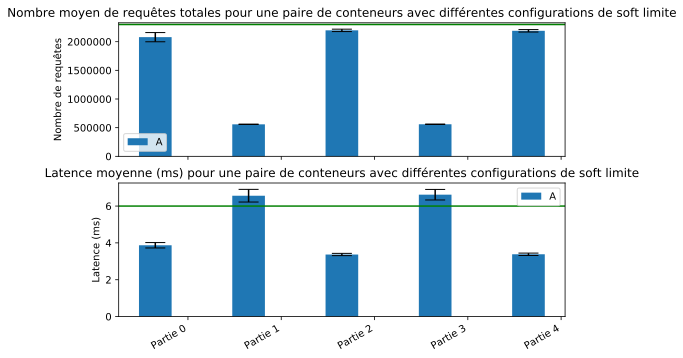

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats


QUERIES_REF = 2300000
LATENCY_REF = 6

DIR = 'alone_max_1800M'
FILES = {'A': ['container_S_silly_roentgen_1800M.out.csv']}

# xtick labels for the bar chart.
NAMES = ['Partie 0', 'Partie 1', 'Partie 2', 'Partie 3', 'Partie 4']
# The width of the bars.
WIDTH = .35

dictionnary = {}

for key in FILES:
        dictionnary[key] = {'request': {'mean': [], 'std': []}, 'latency': {'mean': [], 'std': []}}
    
for key in FILES:
    for file in FILES[key]:
        # Get data from CSV file.
        df = pd.read_csv(DIR + '/' + file, ';')
        values = df.values

        for i in range(len(NAMES)):
            # Computing mean and standard deviation.
            # values is a numpy.ndarray i.e an array of tuples.
            # mean() and std() take an axis as argument and return a tuple.
            # [1] permits to obtain second member of tuple.
            # The queries are the first csv field (+ 1 because of the run column).
            dictionnary[key]['request']['mean'].append(values.mean(0)[1 + i])
            dictionnary[key]['request']['std'].append(values.std(0)[1 + i])
            
            dictionnary[key]['latency']['mean'].append(values.mean(0)[1 + len(NAMES) + i])
            dictionnary[key]['latency']['std'].append(values.std(0)[1 + len(NAMES) + i])

x_pos = np.arange(len(NAMES))

# Axis and figure initialization.
fig, (request_ax, latency_ax) = plt.subplots(nrows = 2, figsize = (8, 6))

request_groups = []
latency_groups = []

# sort the keys so order is correct.
sorted_keys = sorted(FILES.keys())

for key in sorted_keys:
    request_groups.append(request_ax.bar(x_pos, dictionnary[key]['request']['mean'], WIDTH, yerr = dictionnary[key]['request']['std'], align = 'center', capsize = 10))
    latency_groups.append(latency_ax.bar(x_pos, dictionnary[key]['latency']['mean'], WIDTH, yerr = dictionnary[key]['latency']['std'], align = 'center', capsize = 10))
    # Shift the position the second bar by width.
    x_pos = x_pos + WIDTH

request_ax.axhline(y = QUERIES_REF, color = 'green', label = 'ref')
latency_ax.axhline(y = LATENCY_REF, color = 'green', label = 'ref')

request_ax.set_ylabel('Nombre de requêtes')
request_ax.set_xticks(x_pos)
request_ax.set_xticklabels(NAMES)
request_ax.legend(request_groups, sorted_keys)
request_ax.set_title("Nombre moyen de requêtes totales pour une paire de conteneurs avec différentes configurations de soft limite")

latency_ax.set_ylabel('Latence (ms)')
latency_ax.set_xticks(x_pos)
latency_ax.set_xticklabels(NAMES)
latency_ax.legend(request_groups, sorted_keys)
latency_ax.set_title("Latence moyenne (ms) pour une paire de conteneurs avec différentes configurations de soft limite")

fig.autofmt_xdate()
# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Le comportement observé précédemment se confirme aussi ici.
Le conteneur frôle les performances de référence.

Intéressons nous maintenant à l'usage mémoire du conteneur et aux lectures qu'il effectue depuis le disque :

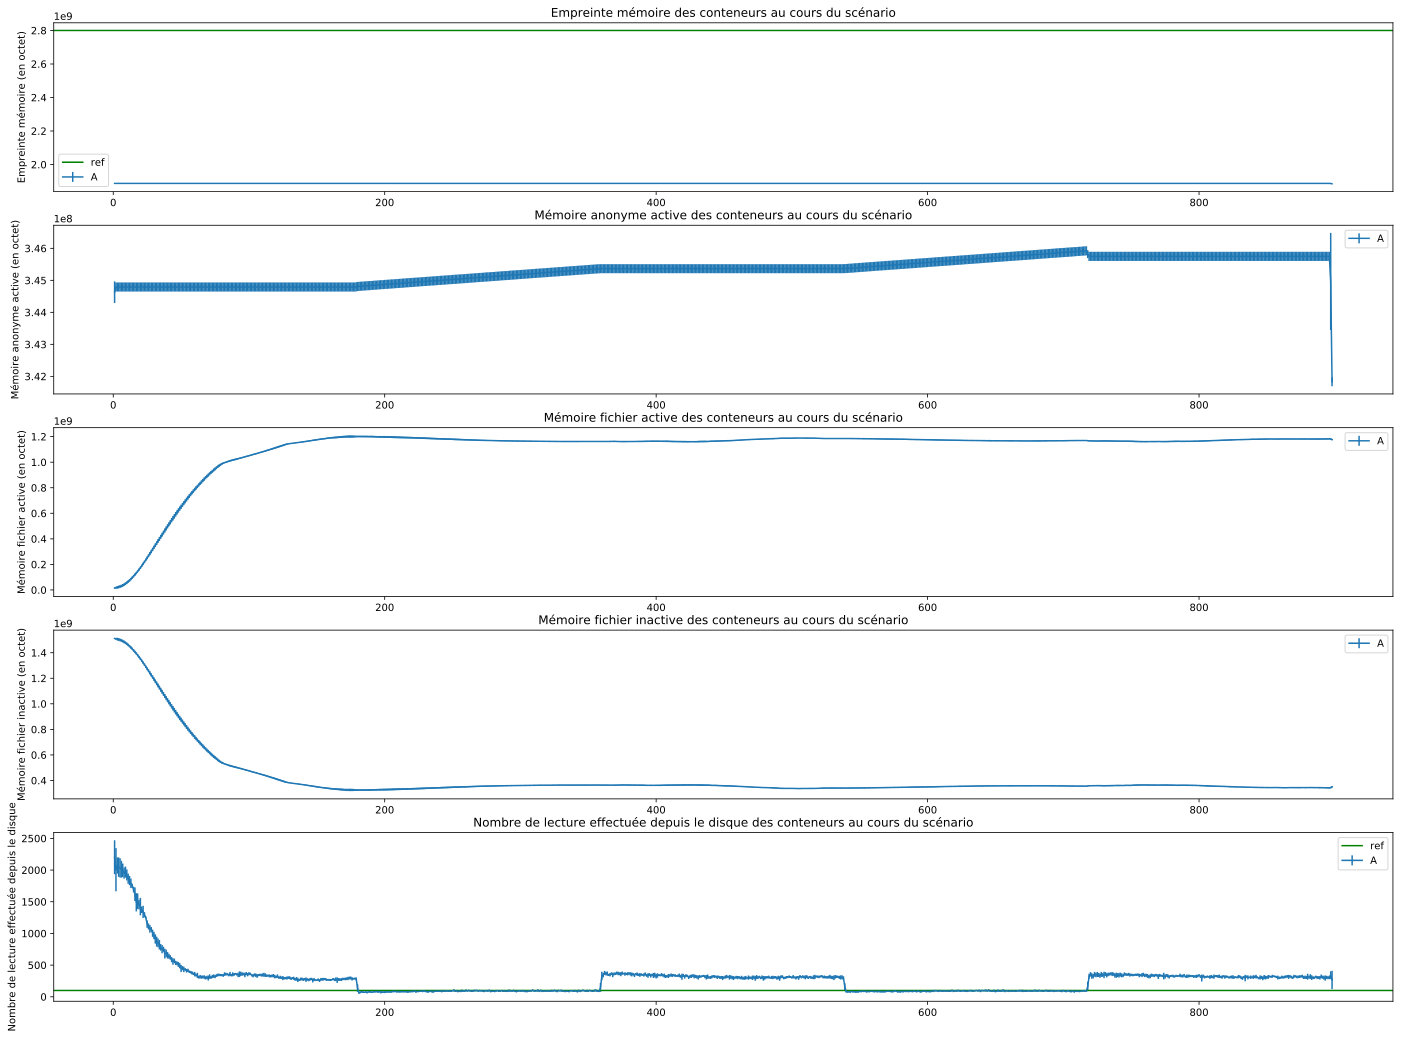

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats


USAGE_REF = 2.8 * 10 ** 9
READS_REF = 100

NAMES = ['768MB']

DIR = 'alone_max_1800M'
FILES = {'A': ['container_S_silly_roentgen_1800M.stats.csv']}

DURATION = 900

dictionnary = {}

for key in FILES:
    dictionnary[key] = {'usage': {}, 'active_anon': {}, 'active_file': {}, 'inactive_file': {}, 'reads': {}}
    
for key in FILES:
    for file in FILES[key]:
        # Get data from CSV file.
        df = pd.read_csv(DIR + '/' + file, ';')
        values = df.values

        # The first record has strange standard deviation values so we do not get it.
        dictionnary[key]['usage']['means'] =values.take(1, axis = 1)[1 : len(values) - 1]
        dictionnary[key]['usage']['stds'] = values.take(2, axis = 1)[1 : len(values) - 1]

        dictionnary[key]['active_anon']['means'] = values.take(3, axis = 1)[1 : len(values) - 1]
        dictionnary[key]['active_anon']['stds'] = values.take(4, axis = 1)[1 : len(values) - 1]
        
        dictionnary[key]['active_file']['means'] = values.take(5, axis = 1)[1 : len(values) - 1]
        dictionnary[key]['active_file']['stds'] = values.take(6, axis = 1)[1 : len(values) - 1]
        
        dictionnary[key]['inactive_file']['means'] = values.take(9, axis = 1)[1 : len(values) - 1]
        dictionnary[key]['inactive_file']['stds'] = values.take(10, axis = 1)[1 : len(values) - 1]
        
        dictionnary[key]['reads']['means'] = values.take(21, axis = 1)[1 : len(values) - 1]
        dictionnary[key]['reads']['stds'] = values.take(22, axis = 1)[1 : len(values) - 1]

# xtick labels for the bar chart.
x_pos = np.arange(len(range(DURATION)))

fig, (usage_ax, active_anon_ax, active_file_ax, inactive_file_ax, reads_ax) = plt.subplots(nrows = 5, figsize = (24, 18))

for key in sorted(FILES.keys()):
    for i in range(len(NAMES)):
        usage_ax.errorbar(x_pos[1 : len(x_pos) - 1], dictionnary[key]['usage']['means'], yerr = dictionnary[key]['usage']['stds'], label = key)
        active_anon_ax.errorbar(x_pos[1 : len(x_pos) - 1], dictionnary[key]['active_anon']['means'], yerr = dictionnary[key]['active_anon']['stds'], label = key)
        active_file_ax.errorbar(x_pos[1 : len(x_pos) - 1], dictionnary[key]['active_file']['means'], yerr = dictionnary[key]['active_file']['stds'], label = key)
        inactive_file_ax.errorbar(x_pos[1 : len(x_pos) - 1], dictionnary[key]['inactive_file']['means'], yerr = dictionnary[key]['inactive_file']['stds'], label = key)
        reads_ax.errorbar(x_pos[1 : len(x_pos) - 1], dictionnary[key]['reads']['means'], yerr = dictionnary[key]['reads']['stds'], label = key)
        
usage_ax.axhline(y = USAGE_REF, color = 'green', label = 'ref')
reads_ax.axhline(y = READS_REF, color = 'green', label = 'ref')

usage_ax.legend()
usage_ax.set_ylabel('Empreinte mémoire (en octet)')
usage_ax.set_title('Empreinte mémoire des conteneurs au cours du scénario')

active_anon_ax.legend()
active_anon_ax.set_ylabel('Mémoire anonyme active (en octet)')
active_anon_ax.set_title('Mémoire anonyme active des conteneurs au cours du scénario')

active_file_ax.legend()
active_file_ax.set_ylabel('Mémoire fichier active (en octet)')
active_file_ax.set_title('Mémoire fichier active des conteneurs au cours du scénario')

inactive_file_ax.legend()
inactive_file_ax.set_ylabel('Mémoire fichier inactive (en octet)')
inactive_file_ax.set_title('Mémoire fichier inactive des conteneurs au cours du scénario')

reads_ax.legend()
reads_ax.set_ylabel('Nombre de lecture effectuée depuis le disque')
reads_ax.set_title('Nombre de lecture effectuée depuis le disque des conteneurs au cours du scénario')

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

L'empreinte mémoire du conteneur est stable et situe vers 1.8GB.
Cette valeur est celle de sa `max` limite.

Au début de la première partie le conteneur effectue beaucoup de lecture depuis le disque puis ce nombre semble se stabiliser vers 100 lectures par seconde. Lorsque le conteneur doit faire face à un pic de requête il effectue logiquement plus de lecture depuis le disque.

#### Conclusion
Les performances du conteneur atteignent presque les niveaux de référence.
Ceci s'explique par le fait que la taille du working set de `sysbench` se situe environ vers 2GB.

#### Annexe
Le script permettant de lancer le conteneur et d'obtenir des statistiques sur celui-ci est le suivant :
```python
#! /usr/bin/env python3
# SPDX-License-Identifier: MPL-2.0
# Copyright (c) 2019 Francis Laniel <francis.laniel@lip6.fr>
import sys
import docker
import os
import threading
import json
import time
import multiprocessing
import re


"""This python script will start one container with sysbench with the given as
argument soft limits.

It will then run 10 times the SYSBENCH_CONTAINER_A and SYSBENCH_CONTAINER_B in
each container as argument. The output of filebench will be written to a file
and statistics (memory usage in bytes and reads from the disk) will be written
to another file.
"""

# Each run lasts 900 seconds.
DURATION = 900

# S like 'solo'.
CHARS = ['S']

# Containers' DB will be 2G.
# Each will execute with two threads since they have 2 cores.
SYSBENCH_PREPARE_COMMAND = 'sysbench --threads=2 /usr/local/share/sysbench/oltp_read_only.lua --table_size=20000000 prepare'

# Each experiment will be composed of 5 scenarios.
# To be able to do that sysbench was modified and arguments '--scheduled-time'
# and '--scheduled-rate' were introduced.
SYSBENCH_RUN_COMMANDS = {'S' : ['sysbench --threads=2 --time=900 --rate=0 --scheduled-rate=0,200,0,200,0 --scheduled-time=180,360,540,720,900 --report-interval=1 --report_checkpoints=180,360,540,720 /usr/local/share/sysbench/oltp_read_only.lua --table_size=20000000 run']}

# This command is run before each run to force read the whole database and bring
# it in memory.
# WARNING We can not use redirection directly in exec_run. We need to use bash
# to be able to redirect. Thanks Damien for the information and also the
# suggestion of the command.
MYSQL_DUMP_COMMAND = "bash -c 'mysqldump sbtest > /dev/null'"

# Give two virtual cores to each container. The virtual cores are chosen so they
# are on the same physical core (i.e cache are shared).
CONTAINERS_CPUS_SETS = ['0,2']

# Those keys are stored under the stat json object in the memory_stats object.
MEMORY_KEYS = ['active_anon', 'active_file', 'inactive_anon', 'inactive_file', 'unevictable', 'pgfault', 'pgmajfault', 'pgpgin', 'pgpgout']

# 'io_serviced_recursive' gives the number of read, write, etc. while
# 'io_service_bytes_recursive' gives the number of bytes read, written, etc.
IO_KEYS = ['io_serviced_recursive', 'io_service_bytes_recursive']

# The keys added to a temporary dictionary.
KEYS = ['usage'] + MEMORY_KEYS + ['io_serviced_recursive:Read', 'io_service_bytes_recursive:Read']

CPU_INFO = '/proc/cpuinfo'

def monitor_cpu_freq(out, barrier):
	"""This function monitors the cores frequencies every second.
	It writes those information in a csv file.
	:param out: An open in write file object where the frequencies will be
	written.
	:type out: _io.TextIOWrapper
	:param barrier: This function will be launched as a thread with different
	function. This barrier will be used to synchronize the threads when the dump
	of the databases are finished.
	:type barrier: threading.Barrier
	"""
	# Wait the end of MYSQL_DUMP_COMMAND.
	barrier.wait()

	# Get DURATION records.
	for t in range(DURATION):
		# Since data which are in /proc/cpuinfo changes we need to open/close this
		# file every time we want to read the new values.
		cpu_info = open(CPU_INFO, 'r')

		# Put the whole file in content as a string.
		content = ''.join(cpu_info.readlines())

		string = str(t)

		# Get frequency for each core and store it in string.
		for freq in re.findall('cpu MHz\t\t: (\d+\.\d+)', content):
			string += ';%s' % freq
		string += '\n'

		# Write the new line in the csv file.
		out.write(string)

		# Sleep one second to get cpu frequency each second.
		time.sleep(1)

		cpu_info.close()

def thread_func(container, commands, out, stats, barrier):
	"""Run the commands in container and write the output in out.
	This function will be used as a thread.
	:param container: The container in which command will be run. It must already
	been started.
	:type container: docker.models.containers.Container
	:param commands: The commands to run in container.
	:type commands: list of str.
	:param out: An open in write file object where the output of command will be
	written.
	:type out: _io.TextIOWrapper
	:param out: An open in write file object where the stats of the container will
	be written.
	:type out: _io.TextIOWrapper
	:param barrier: This function will be launched as a thread with different
	function. This barrier will be used to synchronize the threads when the dump
	of the databases are finished.
	:type barrier: threading.Barrier
	"""
	container.exec_run(MYSQL_DUMP_COMMAND)

	barrier.wait()

	gen = container.stats()

	for command in commands:
		# Run the benchmark inside the container and write the output to out.
		# exec_run returns a tuple whom second field contains bytes. The decode
		# translate them to a string.
		out.write(container.exec_run(command)[1].decode('utf-8') + '\n')

	statistics = []
	old_values = {}

	# old_values will be used below, this loop initializes it with 0s and
	# with the good keys.
	# The keys are the two last of KEYS (i/o related) and the four last of
	# MEMORY_KEYS (pgfault, pgmajfault, pgpgin and pgpgout).
	for i in KEYS[1 + len(MEMORY_KEYS) - 4:]:
		old_values[i] = 0

	for record in gen:
		# Translate the record in string and translate it to python dictionary.
		# Vive la Joz' ! Bon vivant Docteur bon vivant !
		jason = json.loads(record.decode('utf-8'))

		# Create a new dictionary at each iteration so the statistics's cases are
		# differents.
		chicandier = {'usage': jason['memory_stats']['usage']}

		# Add the interesting memory stats to dictionary.
		# We do not add directly the 4 lasts key because they are accumulation and
		# not instantaneous values.
		for key in MEMORY_KEYS[:-4]:
			chicandier[key] = jason['memory_stats']['stats'][key]

		# Deal specifically with the 4 lasts.
		for key in MEMORY_KEYS[-4:]:
			# Get the difference between this iteration and the previous one.
			val = jason['memory_stats']['stats'][key] - old_values[key]

			# Update the old value. Since it begins at 0 the first value will be
			# quite wrong but I do not think it will be a big problem.
			old_values[key] = jason['memory_stats']['stats'][key]

			# Little trick if the key is not already present.
			# TODO Maybe this if is useless since this code is called each second
			# and chicandier is recreated each second. But it works and I will not
			# loose some time for a little branch...
			if key in chicandier:
				chicandier[key] += val
			else:
				chicandier[key] = val

		for key in IO_KEYS:
			for io in jason['blkio_stats'][key]:
				if io['op'] == 'Read':
					# Reconstruct the key with the jason key and the op.
					true_key = key + ':' + io['op']

					# Get the difference between this iteration and the previous one.
					# The value is the number of read or write for this second. It can be
					# seen as the bandwith.
					val = io['value'] - old_values[true_key]

					# Update the old value. Since it begins at 0 the first value will be
					# quite wrong but I do not think it will be a big problem.
					old_values[true_key] = io['value']

					# Little trick if the key is not already present.
					# TODO Maybe this if is useless since this code is called each second
					# and chicandier is recreated each second. But it works and I will not
					# loose some time for a little branch...
					if true_key in chicandier:
						chicandier[true_key] += val
					else:
						chicandier[true_key] = val

		statistics.append(chicandier)

		# Our filebenches last DURATION seconds so we just want DURATION
		# records since containerd give stats every second.
		if len(statistics) == DURATION:
			break

	# Add the statistics to the stat file.
	for i in range(len(statistics)):
		stats.write('%d' % i)

		# Write each statistics in order.
		for key in KEYS:
			stats.write(';%d' % statistics[i][key])

		stats.write('\n')

def main():
	containers = []
	outs = []
	stats = []

	if len(sys.argv) < 2:
		sys.exit("Usage: %s soft_limit" % sys.argv[0])

	client = docker.from_env()

	for c in CHARS:
		# Launch containers as detached.
		containers.append(client.containers.run('sysbench', auto_remove = True, detach = True, mem_limit = '3G'))

	# Wait 120 seconds so the sysbench container is ready. Indeed, it can be slow
	# because mysql is long to boot.
	time.sleep(120)

	# Open /proc/sys/vm/drop_caches to be able to drop linux page cache.
	drop_cache = open('/proc/sys/vm/drop_caches', 'wb', buffering = 0)

	# Every files created in this script will be stored in this directory.
	# Due to the concatenation of the date it should be unique.
	directory = '%s/%s-%s' % (os.path.expanduser('~'), sys.argv[0], time.ctime().replace(' ', '_'))

	os.mkdir(directory)

	# This file will store cpus' frequencies along experiment.
	freq = open('%s/%s_alone.freq' % (directory, sys.argv[1]), 'w')

	# Write the header.
	freq.write('time')
	for i in range(multiprocessing.cpu_count()):
		freq.write(';cpu%d_frequency' % i)
	freq.write('\n')

	# Run each benchmark once so they are prepared.
	for i in range(len(containers)):
		containers[i].exec_run(SYSBENCH_PREPARE_COMMAND)

		# Set the container limits once its preparation phase is finished.
		# sys.argv[i + 1] because sys.argv[0] is the program name and there are
		# len(sys.argv) - 1 containers.
		containers[i].update(mem_reservation = sys.argv[1], mem_limit = '3G', memswap_limit = '3G', cpuset_cpus = CONTAINERS_CPUS_SETS[i])

		# Drop the cache so the preparation above does not have a consequence on the
		# runs below.
		drop_cache.write(bytearray('3\n', 'utf-8'))

		outs.append(open('%s/container_%c_%s_%s.out' % (directory, CHARS[i], containers[i].name, sys.argv[1]), 'w'))
		stats.append(open('%s/container_%c_%s_%s.stats' % (directory, CHARS[i], containers[i].name, sys.argv[1]), 'w'))

		stats[i].write('iteration;usage;active_anon;active_file;inactive_anon;inactive_file;unevictable;pgfault;pgmajfault;pgpgin;pgpgout;reads;read_bandwith\n')

	# Run each filebench 10 times to compute mean and standard deviation.
	for i in range(10):
		threads = []

		# Declare a threading barrier which will wait 2 threads: one for container
		# and one for monitor_cpu_freq.
		barrier = threading.Barrier(len(CHARS) + 1)

		for j in range(len(containers)):
			# Prepare the threads which will run filebench inside the containers.
			threads.append(threading.Thread(target = thread_func, args = (containers[j], SYSBENCH_RUN_COMMANDS[CHARS[j]], outs[j], stats[j], barrier)))

		# Add the monitor function so cpu frequency will be monitorer while
		# containers run.
		threads.append(threading.Thread(target = monitor_cpu_freq, args = (freq, barrier)))

		# Launch the threads.
		for t in threads:
			t.start()

		# Wait them.
		for t in threads:
			t.join()

		# Drop the cache between each run so they are independents.
		drop_cache.write(bytearray('3\n', 'utf-8'))

		# Force write to files after each run so we can collect stats during
		# the experiment.
		for j in range(len(containers)):
			outs[j].flush()
			stats[j].flush()

		print("[ %s ] Run #%d finished!" % (time.ctime(), i))

	# Stop and close everything.
	for i in range(len(containers)):
		containers[i].stop()

		outs[i].close()
		stats[i].close()

	freq.close()
	drop_cache.close()

if __name__ == "__main__":
	main()
```